# Ironkaggle

In [31]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import plotly.express as px
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import statsmodels.api as sm

### Load Data - Show basics

In [2]:
dataset_csv= pd.read_csv("king_ country_ houses_aa.csv")
dataset = dataset_csv.copy()

# Functions used for Analysis

In [3]:
### Functions - Taken from Anne's Utils.py

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (r2_score,
                             mean_absolute_error,
                             mean_absolute_percentage_error,
                             mean_squared_error,
                             root_mean_squared_error)


from sklearn.base import BaseEstimator
from typing import SupportsFloat, Union, Dict

# Define types for clearer code
ArrayLike = Union[pd.DataFrame, pd.Series, np.ndarray]


def adjusted_r2(y_true: ArrayLike, y_pred: ArrayLike, X: ArrayLike) -> float:
    """
    Calculate Adjusted R2, handling both Arrays and DataFrames.
    """
    r2 = r2_score(y_true, y_pred)
    n = len(y_true)
    
    # Handle X shape safely (whether it's a DataFrame or Numpy array)
    if hasattr(X, 'shape'):
        p = X.shape[1] if len(X.shape) > 1 else 1
    else:
        p = 1 # Fallback for 1D lists
        
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

def create_metrics_df():
    """Create the dataframe to store the metrics

    Returns:
        pd.DataFrame: The empty metrics DataFrame.
    """    
    columns = ["Model","Split", "R2", "Adjusted_R2", "MAE", "RMSE", "MAPE","Comments"]
    metrics_df = pd.DataFrame(columns=columns)
    return metrics_df

def _get_metrics(
    trained_model: BaseEstimator, 
    X: ArrayLike, 
    y: ArrayLike, 
    split: str = "train", 
    comments: str = "Baseline model"
) -> Dict[str, Union[str, float]]:
    """
    Internal function to calculate metrics for a single split.
    
    Args:
        trained_model: A fitted sklearn model.
        X: Feature matrix (DataFrame or Numpy Array).
        y: Target vector (Series or Numpy Array).
        split: Label for the data split (e.g., 'Train', 'Test').
        comments: User notes.

    Returns:
        dict: A dictionary containing all calculated metrics.
    """
    # Generate predictions
    y_pred = trained_model.predict(X)

    # Calculate metrics
    new_row = {
        "Model": trained_model.__class__.__name__,
        "Split": split,
        "R2": np.round(r2_score(y, y_pred), 4),
        "Adjusted_R2": np.round(adjusted_r2(y, y_pred, X), 4),
        "MAE": np.round(mean_absolute_error(y, y_pred), 4),
        "MAPE": np.round(mean_absolute_percentage_error(y, y_pred), 4),
        "RMSE": np.round(root_mean_squared_error(y, y_pred), 4),
        "Comments": comments
    }

    return new_row

def add_new_metrics(
    metrics_df: pd.DataFrame,
    trained_model: BaseEstimator,
    X: ArrayLike,
    y: ArrayLike,
    split: str = "train",
    comments: str = "Baseline model"
) -> pd.DataFrame:
    """
    Calculates metrics and appends them to the tracking DataFrame.
    
    Args:
        metrics_df: The existing DataFrame to update.
        trained_model: A fitted sklearn model.
        X: Feature matrix.
        y: Target vector.
        split: "Train" or "Test".
        comments: Notes about this run.
        
    Returns:
        pd.DataFrame: The updated DataFrame with the new row.
    """
    
    # Get the metrics dictionary
    new_row_dict = _get_metrics(trained_model, X, y, split, comments)
    
    # Create a DataFrame from the new row
    new_row_df = pd.DataFrame([new_row_dict])
    
    # Concatenate and RETURN the result
    if metrics_df.empty:
        return new_row_df
    else:
        updated_df = pd.concat([metrics_df, new_row_df], ignore_index=True)
    
    return updated_df

def generate_heatmap(X):
    # 1. Calculate correlation
    corr = np.round(np.abs(X.corr()), 2)
    
    # 2. Create the mask (True for upper triangle and diagonal)
    mask = np.zeros_like(corr, dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    
    # 3. Slice the matrix and mask to remove the completely empty row/column
    #    Row 0 is fully masked (hidden), Column -1 is fully masked (hidden)
    corr_sliced = corr.iloc[1:, :-1]
    mask_sliced = mask[1:, :-1]

    f, ax = plt.subplots(figsize=(16, 16))

    # 4. Plot using the sliced data
    #    Note: annot=True is safer than annot=corr when slicing
    sns.heatmap(
        corr_sliced, 
        mask=mask_sliced, 
        annot=True,          # Use True to automatically label values
        square=True, 
        linewidths=.5, 
        vmax=1
    )
    plt.show()


    from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def get_r_squared(y_train, y_test, y_pred_train, y_pred_test):
    """Get the r2 for train and test and print the values.

    Args:
        y_train (_type_): Ground Truth target values for the train.
        y_test (_type_): Ground Truth target values for the test.
        y_pred_train (_type_): Predicted values for the train.
        y_pred_test (_type_): Predicted values for the test.

    Returns:
        tuple: tuple containing the r2 for the train and the test in that order.
    """
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)

    print_metrics("R2", r2_train, r2_test)
    return (r2_train, r2_test)

def get_mse(y_train, y_test, y_pred_train, y_pred_test):
    """Get the mse for train and test and print the values.

    Args:
        y_train (_type_): Ground Truth target values for the train.
        y_test (_type_): Ground Truth target values for the test.
        y_pred_train (_type_): Predicted values for the train.
        y_pred_test (_type_): Predicted values for the test.

    Returns:
        tuple: tuple containing the mse for the train and the test in that order.
    """
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)

    print_metrics("MSE", mse_train, mse_test)
    return (mse_train, mse_test)

def get_mae(y_train, y_test, y_pred_train, y_pred_test):
    """Get the mae for train and test and print the values.

    Args:
        y_train (_type_): Ground Truth target values for the train.
        y_test (_type_): Ground Truth target values for the test.
        y_pred_train (_type_): Predicted values for the train.
        y_pred_test (_type_): Predicted values for the test.

    Returns:
        tuple: tuple containing the mae for the train and the test in that order.
    """
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred_test)

    print_metrics("MSE", mae_train, mae_test)
    return (mae_train, mae_test)

def print_metrics(metric_name:str, train_score:SupportsFloat, test_score:SupportsFloat):
    string = f"""
    {metric_name} score:
    train | {train_score}
    test  | {test_score}
    """

    print(string)

# Basic Data Inspection 

In [4]:
# Basic Data Inspection

# Check Shape of the Dataset
print(f"Dataset Shape : {dataset.shape[0]} rows x {dataset.shape[1]}")

# Check Column Names of the Dataset
print(f"\nColumn Names : {dataset.columns.tolist()}")

# Temp Dataset
dataset_alt = dataset.copy()

# Missing Values Check
print("\nCheck for possible Null Values:")
missingVal = dataset.isnull().sum()
print(missingVal)
if missingVal.sum() == 0:
    print("NO Missing Values found")


# Check for duplicates
print(f"\nChecking for Dupicates :")
duplicatesVal = dataset.duplicated().sum()
if duplicatesVal == 0:
    print(f"No Duplicates found")

Dataset Shape : 21613 rows x 21

Column Names : ['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']

Check for possible Null Values:
id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64
NO Missing Values found

Checking for Dupicates :
No Duplicates found


# Feature Engineering

#### Proposal
- Convert Date Colummn to Pandas Data-Time series and extract 3 new columns : day,month and year.
- Create 2 new columns called : Year_Since_Renovation and Was_Renovated(booolean)

In [5]:
# Convert Date Column to Day,month and Year
dataset_alt.date = pd.to_datetime(dataset_alt.date)
dataset_alt["year_sold"] = dataset_alt.date.dt.year
dataset_alt["month_sold"] = dataset_alt.date.dt.month
dataset_alt["day_sold"] = dataset_alt.date.dt.day

# Selected features for FEATURE ENGINEERING
dataset_alt['yr_built'] = pd.to_numeric(dataset_alt['yr_built'], errors='coerce')
dataset_alt['yr_renovated'] = pd.to_numeric(dataset_alt['yr_renovated'], errors='coerce')
dataset_alt['year_sold'] = pd.to_numeric(dataset_alt['year_sold'], errors='coerce')

# Add Columns : Age at Sale, Year since renovation, Was Renovated(bool) to the Dataset
dataset_alt["Age_at_Sale"] = dataset_alt["year_sold"] - dataset_alt["yr_built"]

dataset_alt["Year_since_Renovation"] = dataset_alt["year_sold"] - dataset_alt["yr_renovated"]

dataset_alt.loc[dataset_alt["yr_renovated"] == 0, "Year_since_Renovation"] = dataset_alt["year_sold"] - dataset_alt["yr_built"]

print(f"\nColumn Names : {dataset_alt.columns.tolist()}")

dataset_alt["was_renovated"] = (dataset_alt["yr_renovated"] > 0) & (dataset_alt["yr_renovated"] > dataset_alt["yr_built"])

print(f"\nData Type of columns :\n{dataset_alt.dtypes}")

Cleaned_Dataset = dataset_alt.drop(columns = ["date", "id", "yr_built", "year_sold", "month_sold" ]) # yr_built, year_sold
Cleaned_Dataset.info()
print(f"\nColumn Names : {Cleaned_Dataset.columns.tolist()}")
Cleaned_Dataset.to_csv("king_country_houses_fe.csv", index=False)


Column Names : ['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'year_sold', 'month_sold', 'day_sold', 'Age_at_Sale', 'Year_since_Renovation']

Data Type of columns :
id                                int64
date                     datetime64[ns]
price                           float64
bedrooms                          int64
bathrooms                       float64
sqft_living                       int64
sqft_lot                          int64
floors                          float64
waterfront                        int64
view                              int64
condition                         int64
grade                             int64
sqft_above                        int64
sqft_basement                     int64
yr_built                          int64
yr_renovated                      i

# Split Data for train_test_split

- Here we split the Data : 
    - X - Holds the Cleaned Dataset without PRICE 
    - Y - Holds the Cleaned Dataset with only PRICE



In [6]:
X = Cleaned_Dataset.drop(columns = ["price"])
y = Cleaned_Dataset["price"]
seed = 13

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

print(f"X_train Training Samples: {X_train.shape[0]}")
print(f"X_test Samples: {X_test.shape[0]}")
print(f"Y_train Training Samples: {y_train.shape[0]}")
print(f"Y_test Training Samples: {y_test.shape[0]}")


print(f"Split: {len(X_train)} train ({len(X_train)/len(Cleaned_Dataset):.1%}) | "
      f"{len(X_test)} test ({len(X_test)/len(Cleaned_Dataset):.1%})")

X_train Training Samples: 17290
X_test Samples: 4323
Y_train Training Samples: 17290
Y_test Training Samples: 4323
Split: 17290 train (80.0%) | 4323 test (20.0%)


# Correlation
    - Here a simple correlation without controlling any parameters is done.
    - And consquently a Heatmap


Correlation Analysis :
                       price  bedrooms  bathrooms  sqft_living  sqft_lot  \
price                  1.000     0.308      0.525        0.702     0.090   
bedrooms               0.308     1.000      0.516        0.577     0.032   
bathrooms              0.525     0.516      1.000        0.755     0.088   
sqft_living            0.702     0.577      0.755        1.000     0.173   
sqft_lot               0.090     0.032      0.088        0.173     1.000   
floors                 0.257     0.175      0.501        0.354    -0.005   
waterfront             0.266    -0.007      0.064        0.104     0.022   
view                   0.397     0.080      0.188        0.285     0.075   
condition              0.036     0.028     -0.125       -0.059    -0.009   
grade                  0.667     0.357      0.665        0.763     0.114   
sqft_above             0.606     0.478      0.685        0.877     0.184   
sqft_basement          0.324     0.303      0.284        0.435  

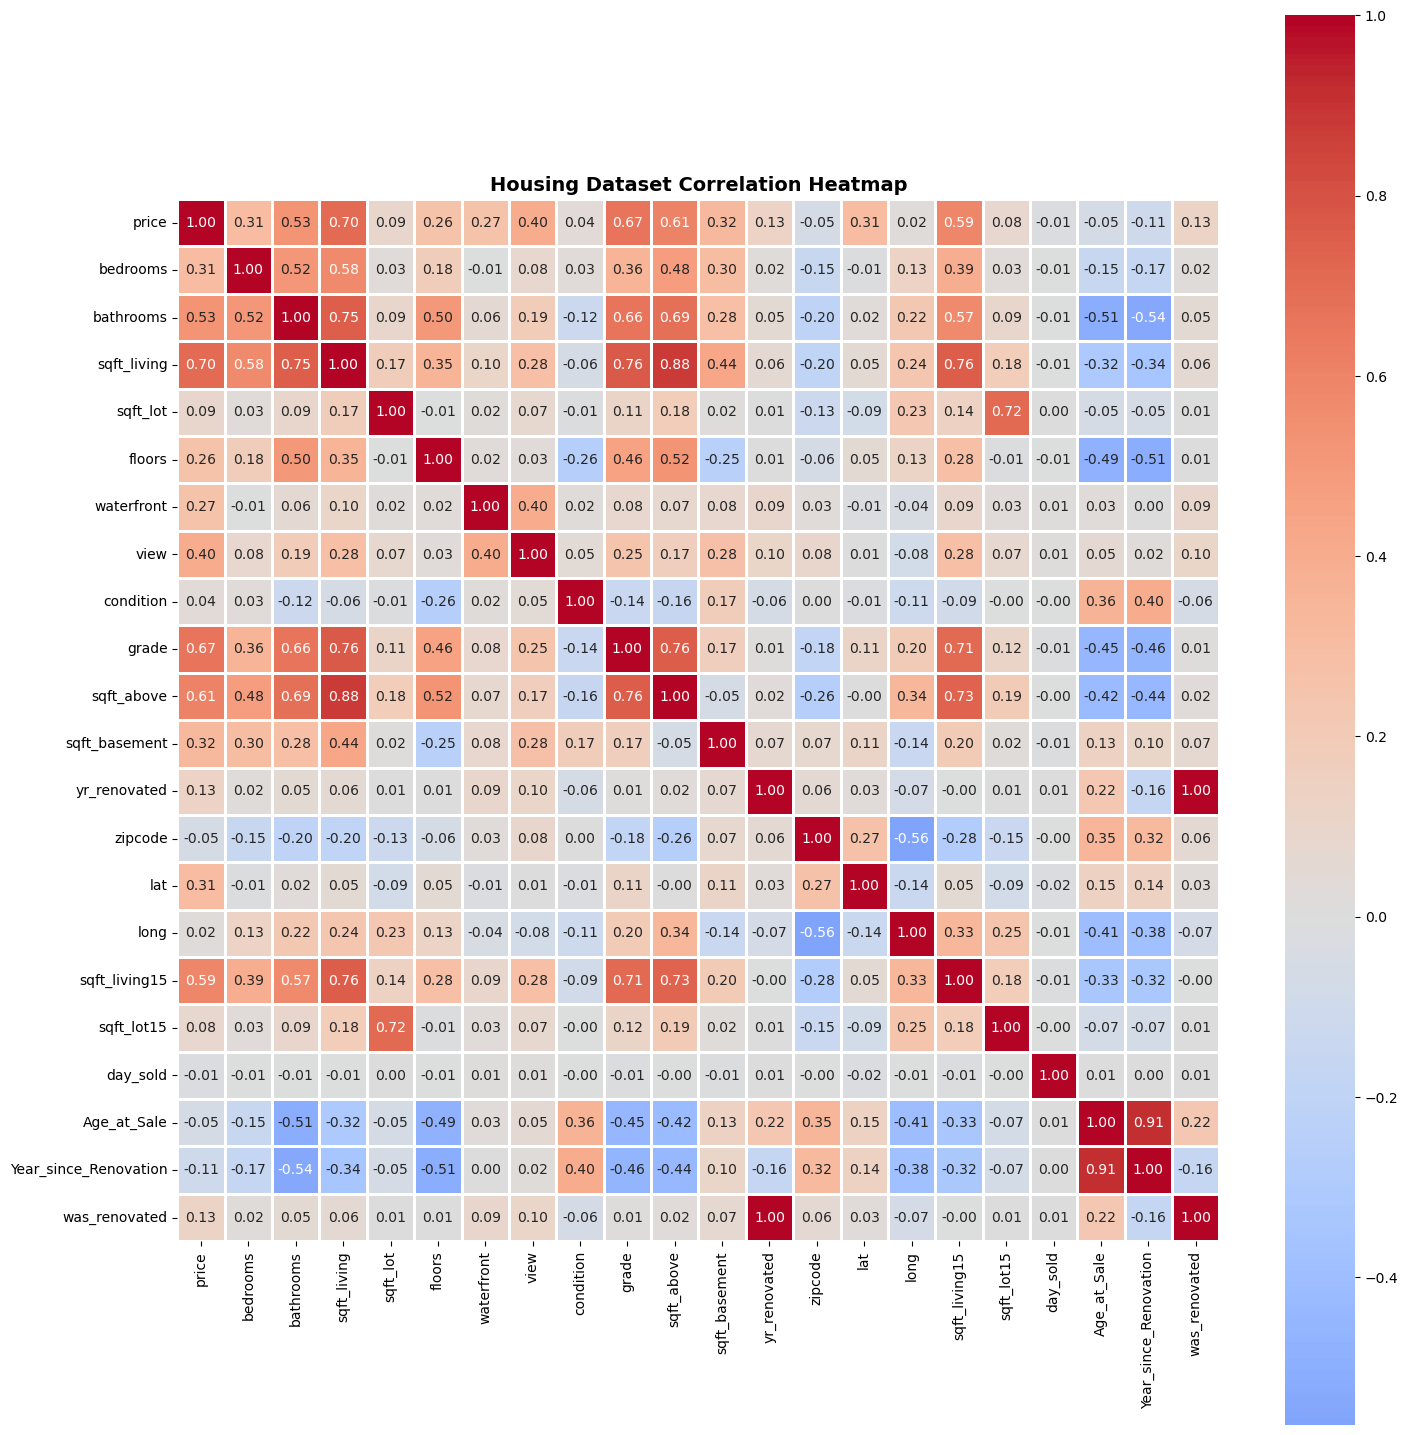

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [7]:
check_correlation = Cleaned_Dataset.corr()
print("\nCorrelation Analysis :")
print(check_correlation.round(3))

# Plot correlation Heatmap

plt.figure(figsize=(15,15))
sns.heatmap(check_correlation,annot=True, cmap='coolwarm',center=0,fmt='.2f',square=True,linewidths=1)
plt.title("Housing Dataset Correlation Heatmap", fontsize=14,fontweight='bold')
plt.tight_layout()
plt.show()
plt.figure()

# Parameterized Heatmap

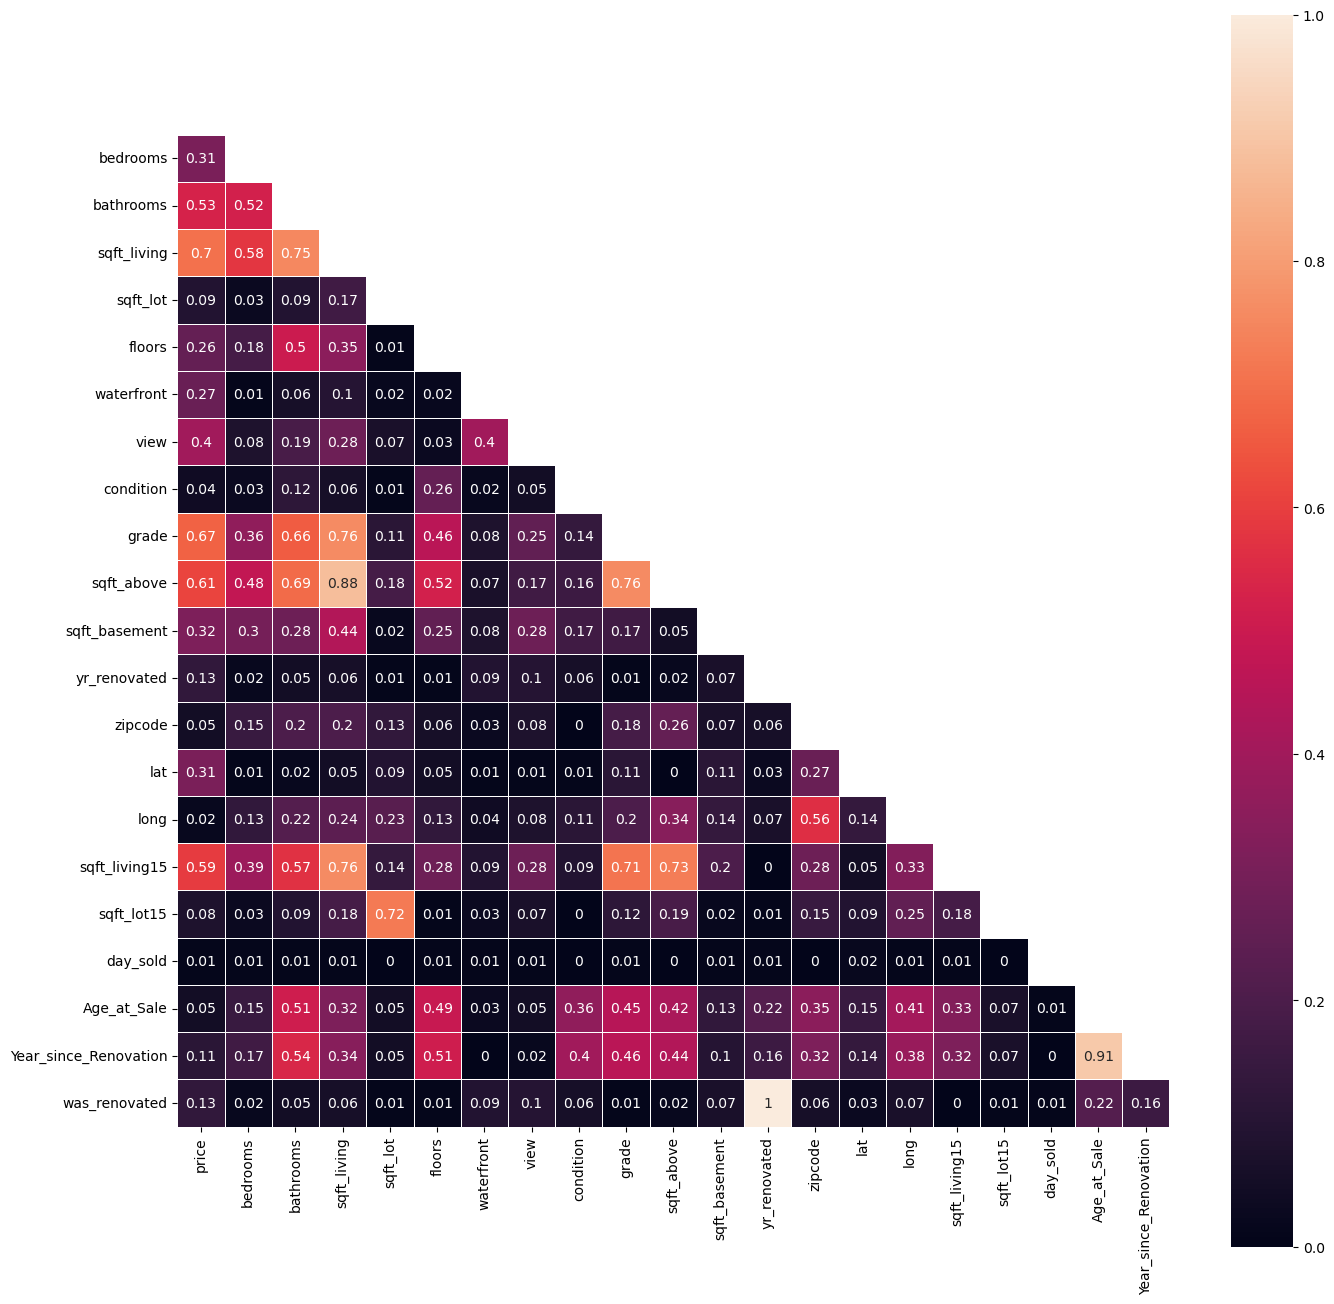

In [8]:
generate_heatmap(Cleaned_Dataset)

# Feature Importance
    - Lasso Regularization
    

In [9]:
std_scaler = StandardScaler()

X_train_standard = std_scaler.fit_transform(X_train)
X_test_standard = std_scaler.fit_transform(X_test)

print(X_train_standard.min(), X_train_standard.max())

-3.956684808851382 39.35388067380475


In [10]:
features = X_train.columns
features

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'day_sold', 'Age_at_Sale',
       'Year_since_Renovation', 'was_renovated'],
      dtype='object')

In [11]:
from IPython.display import clear_output

lasso_regressor = Lasso(random_state=seed)

lasso_regressor.fit(X_train_standard, y_train)

# Remove warning 
clear_output()

In [12]:
# Regression coefficients

coefs_lasso = pd.Series(np.abs(lasso_regressor.coef_), features).sort_values(ascending=False)

coefs_lasso

sqft_living              260667.308014
yr_renovated             115539.976929
grade                    113464.284916
was_renovated            105055.743718
lat                       83899.034194
sqft_above                81996.071094
Age_at_Sale               70493.906203
sqft_basement             59474.251516
waterfront                49347.059323
view                      39356.052812
bedrooms                  33745.986217
bathrooms                 32306.386441
long                      31980.674767
zipcode                   31606.104587
condition                 16509.503473
sqft_living15             14330.914670
sqft_lot15                10419.853206
Year_since_Renovation      6825.039435
sqft_lot                   4926.447704
day_sold                   3153.359687
floors                     2301.221136
dtype: float64

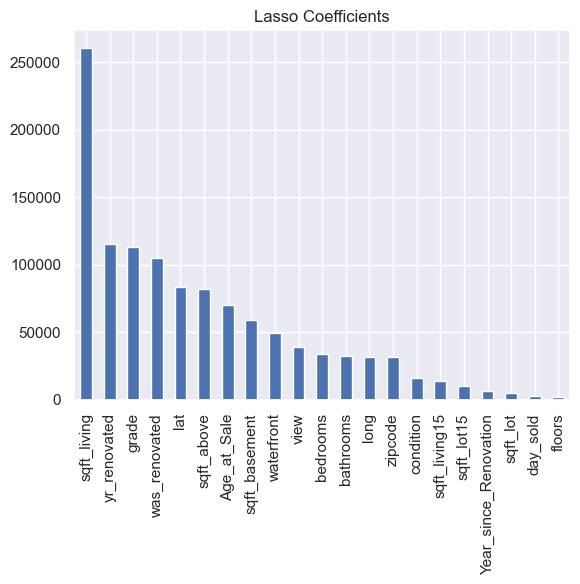

In [13]:
sns.set_theme()
coefs_lasso.plot(kind='bar', title='Lasso Coefficients')
fig1 = plt.savefig("Graphs/Lasso_Coefficients.png")

# Ridge (L2 Regularization)
    - Reduces coefficients magnitudes for correlated features. Should give us an idea of        multicollinearity.

In [14]:
ridge_regressor = Ridge(random_state=seed)
ridge_regressor.fit(X_train_standard, y_train)


# Regression coefficients

coefs_ridge = pd.Series(np.abs(ridge_regressor.coef_), features).sort_values(ascending=False)

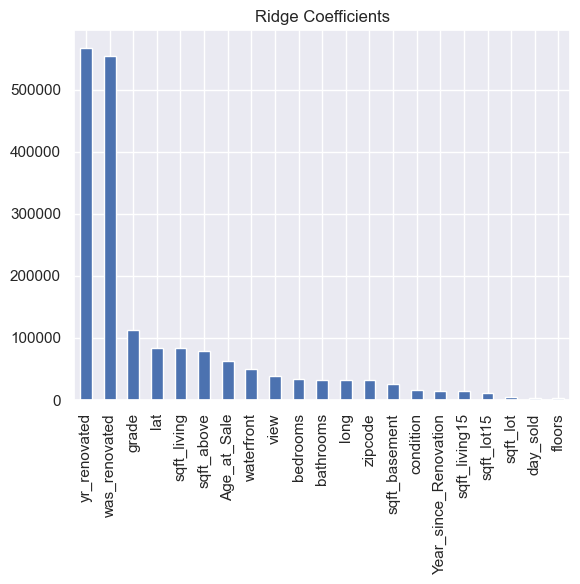

In [15]:
sns.set_theme()
coefs_ridge.plot(kind='bar', title='Ridge Coefficients')
fig1 = plt.savefig("Graphs/Ridge_Coefficients.png")

# Lasso vs Ridge

In [16]:
# combined

feature_importance = pd.DataFrame({"lasso": coefs_lasso, "ridge": coefs_ridge})

In [17]:
feature_importance = feature_importance.reset_index()
feature_importance

,index,lasso,ridge
0,Age_at_Sale,70493.906203,62758.474492
1,Year_since_Renovation,6825.039435,14832.195034
2,bathrooms,32306.386441,32258.641807
3,bedrooms,33745.986217,33822.267903
4,condition,16509.503473,16613.195141
5,day_sold,3153.359687,3174.078409
6,floors,2301.221136,2587.054029
7,grade,113464.284916,113284.414558
8,lat,83899.034194,83883.757531
9,long,31980.674767,31943.753755


In [18]:
import pandas as pd
import plotly.express as px

# Fix formating of the dataframe for plotting
df_melted = feature_importance.melt(id_vars='index', 
                     value_vars=['lasso', 'ridge'],
                     var_name='Model', 
                     value_name='Coefficient')

# Create a interactive bar plot
fig = px.bar(df_melted.sort_values("Coefficient", ascending=False), 
             x='index', 
             y='Coefficient', 
             color='Model',          
             barmode='group',        # side-by-side, not stacked
            color_discrete_map={
                 'lasso': '#4c72b0', 
                 'ridge': '#dd8452'},
             title='Feature Importance: Lasso vs Ridge')

# 3. Rotate x-axis labels
fig.update_layout(
    xaxis_tickangle=-45,
    xaxis_title='Features',
    yaxis_title='Absolute Coefficient Value'
)

fig.show()
fig.write_image("Graphs/Lasso_Ridge_Coefficients.png")


# Linear Regression
    - Given Numeriacal Dataset we perform a Linear Regression and start creating metrics

In [19]:
from sklearn.linear_model import LinearRegression

# Create Estimator
LinReg = LinearRegression()

# Perform Fitting
LinReg.fit(X_train, y_train)

# Make Predictions
y_train_predict = LinReg.predict(X_train)
y_test_predict = LinReg.predict(X_test)

print("Model trained successfully!")
print(f"Training predictions shape: {y_train_predict.shape}")
print(f"Testing predictions shape: {y_test_predict.shape}")
print(f"\nFirst 5 training predictions: {y_train_predict[:5]}")
print(f"First 5 actual training values: {y_train.iloc[:5].values}")

print(f"Intercept: {LinReg.intercept_:.2f}")
print(f"Number of coefficients: {len(LinReg.coef_)}")
print(f"\nTop3 Influential features:")
feature_importance = sorted(zip(X_train.columns,LinReg.coef_),key=lambda x:abs(x[1]), reverse=True)[:3]
for feat, coef in feature_importance:
    print(f"{feat}:  {coef:.4f}")

metrics_df = create_metrics_df()

metrics_df = add_new_metrics(metrics_df,LinReg, X_train, y_train, split="train", comments="Linear Regression FE Metrics - train - dropped features: date, id, yr_built, year_sold, month_sold")
metrics_df = add_new_metrics(metrics_df,LinReg, X_test, y_test, split="test", comments="Linear Regression FE Metrics - test - dropped features: date, id, yr_built, year_sold, month_sold")

metrics_df




Model trained successfully!
Training predictions shape: (17290,)
Testing predictions shape: (4323,)

First 5 training predictions: [247834.7561139  728804.13253798 810711.97302496 216848.11429534
  90564.97897474]
First 5 actual training values: [284950. 625000. 838400. 282000. 218000.]
Intercept: 1355520.65
Number of coefficients: 21

Top3 Influential features:
was_renovated:  -9156171.3570
lat:  604623.1733
waterfront:  583972.7739


,Model,Split,R2,Adjusted_R2,MAE,MAPE,RMSE,Comments
0,LinearRegression,train,0.6977,0.6973,125914.8975,0.2557,202891.3616,Linear Regression FE Metrics - train - dropped...
1,LinearRegression,test,0.7165,0.7151,125994.7484,0.2590,191439.9182,Linear Regression FE Metrics - test - dropped ...


# Mean Sq Error, Mean Absolute Error, Root Mean Squared Error



In [20]:
get_mse(y_train, y_test, y_train_predict, y_test_predict)

get_r_squared(y_train, y_test, y_train_predict, y_test_predict)

get_mae(y_train, y_test, y_train_predict, y_test_predict)





    MSE score:
    train | 41164904608.63687
    test  | 36649242289.43816
    

    R2 score:
    train | 0.697664220549328
    test  | 0.716453297645963
    

    MSE score:
    train | 125914.89749025984
    test  | 125994.74837969066
    


(125914.89749025984, 125994.74837969066)

# Random Forest - Regression
    - Random Forrest Regressor is applied, again without controlling any parameters.

In [21]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

rf_regressor = RandomForestRegressor(n_estimators=110,random_state=seed)

rf_regressor.fit(X_train, y_train)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",110
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsample

### Predictions 

In [22]:
y_pred = rf_regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared Score: {r2:.2f}")

single_data = X_test.iloc[0].values.reshape(1, -1)
predicted_value = rf_regressor.predict(single_data)
print(f"Predicted Value: {predicted_value[0]:.2f}")
print(f"Actual Value: {y_test.iloc[0]:.2f}")



metrics_df = add_new_metrics(metrics_df, rf_regressor, X_train, y_train, split="train", comments="Random Forest Train FE Metrics - train - dropped features: date, id, yr_built, year_sold, month_sold")
metrics_df = add_new_metrics(metrics_df,rf_regressor, X_test, y_test, split="test", comments="Random Forest Test FE Metrics - test - dropped features: date, id, yr_built, year_sold, month_sold")

metrics_df



Mean Squared Error: 13500260163.85
R-squared Score: 0.90
Predicted Value: 290463.59
Actual Value: 324900.00


c:\Users\KaoticCharma\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names



,Model,Split,R2,Adjusted_R2,MAE,MAPE,RMSE,Comments
0,LinearRegression,train,0.6977,0.6973,125914.8975,0.2557,202891.3616,Linear Regression FE Metrics - train - dropped...
1,LinearRegression,test,0.7165,0.7151,125994.7484,0.2590,191439.9182,Linear Regression FE Metrics - test - dropped ...
2,RandomForestRegressor,train,0.9820,0.9820,25980.2304,0.0486,49538.9365,Random Forest Train FE Metrics - train - dropp...
3,RandomForestRegressor,test,0.8956,0.8950,67606.7385,0.1280,116190.6199,Random Forest Test FE Metrics - test - dropped...


# Random Forest - Regression with Feature Importance
    - Random Forrest Regressor is applied, again without controlling any parameters.

In [23]:
from sklearn.ensemble import RandomForestRegressor

rf_regressor = RandomForestRegressor(random_state=seed)#default values + random_state = 13
rf_regressor.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsample

In [24]:
y_pred = rf_regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared Score: {r2:.2f}")

single_data = X_test.iloc[0].values.reshape(1, -1)
predicted_value = rf_regressor.predict(single_data)
print(f"Predicted Value: {predicted_value[0]:.2f}")
print(f"Actual Value: {y_test.iloc[0]:.2f}")


Mean Squared Error: 13619426178.18
R-squared Score: 0.89
Predicted Value: 289293.45
Actual Value: 324900.00


c:\Users\KaoticCharma\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names



In [25]:
features = X_train.columns
coefs_rf = pd.Series(np.abs(rf_regressor.feature_importances_), features).sort_values(ascending=False)

metrics_df = add_new_metrics(metrics_df, rf_regressor, X_train, y_train, split="train", comments="Random Forest Train FE + FI  Metrics - train - dropped features: date, id, yr_built, year_sold, month_sold")
metrics_df = add_new_metrics(metrics_df,rf_regressor, X_test, y_test, split="test", comments="Random Forest Test FE + FI Metrics - test - dropped features: date, id, yr_built, year_sold, month_sold")

coefs_rf



grade                    0.313535
sqft_living              0.274619
lat                      0.159416
long                     0.070064
sqft_living15            0.030581
waterfront               0.025367
Age_at_Sale              0.020887
sqft_above               0.019248
zipcode                  0.012981
sqft_lot                 0.012404
view                     0.011900
sqft_lot15               0.011859
day_sold                 0.007335
Year_since_Renovation    0.007207
bathrooms                0.006546
sqft_basement            0.006109
bedrooms                 0.003223
condition                0.002707
floors                   0.001969
yr_renovated             0.001513
was_renovated            0.000530
dtype: float64

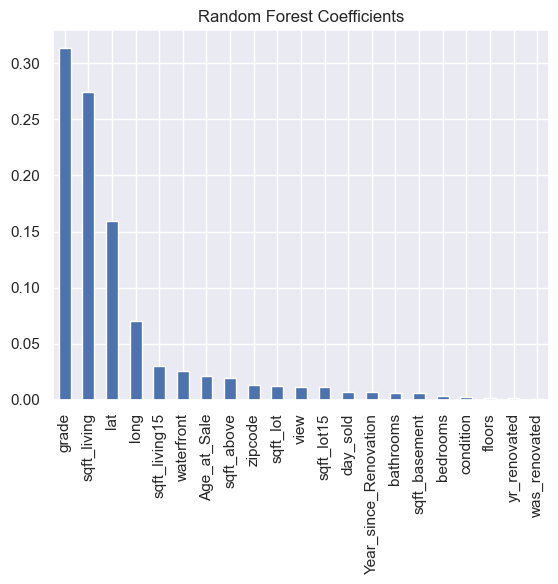

In [26]:
coefs_rf.plot(kind='bar', title='Random Forest Coefficients')
fig1 = plt.savefig("Graphs/RandomForest_Coefficients.png")

# XGBoost

In [27]:
xgb_regressor = xgb.XGBRegressor(n_estimators=100, random_state=seed)

xgb_regressor.fit(X_train, y_train)

metrics_df = add_new_metrics(metrics_df, xgb_regressor, X_train, y_train, split="train", comments="XGBoost Train FE Metrics - train - dropped features - date, id, yr_built, year_sold, month_sold")
metrics_df = add_new_metrics(metrics_df, xgb_regressor, X_test, y_test, split="test", comments="XGBoost Test FE Metrics - test - dropped features - date, id, yr_built, year_sold, month_sold")

metrics_df

metrics_df.to_csv("ModelMetrics_FE.csv", index=False)

metrics_df


,Model,Split,R2,Adjusted_R2,MAE,MAPE,RMSE,Comments
0,LinearRegression,train,0.6977,0.6973,125914.8975,0.2557,202891.3616,Linear Regression FE Metrics - train - dropped...
1,LinearRegression,test,0.7165,0.7151,125994.7484,0.2590,191439.9182,Linear Regression FE Metrics - test - dropped ...
2,RandomForestRegressor,train,0.9820,0.9820,25980.2304,0.0486,49538.9365,Random Forest Train FE Metrics - train - dropp...
3,RandomForestRegressor,test,0.8956,0.8950,67606.7385,0.1280,116190.6199,Random Forest Test FE Metrics - test - dropped...
4,RandomForestRegressor,train,0.9819,0.9819,26031.4643,0.0487,49598.7780,Random Forest Train FE + FI Metrics - train -...
5,RandomForestRegressor,test,0.8946,0.8941,67781.7366,0.1283,116702.2972,Random Forest Test FE + FI Metrics - test - dr...
6,XGBRegressor,train,0.9761,0.9761,40791.8177,0.0903,57067.4036,XGBoost Train FE Metrics - train - dropped fea...
7,XGBRegressor,test,0.9038,0.9033,66773.7091,0.1271,111527.5852,XGBoost Test FE Metrics - test - dropped featu...


# XGBoost with Feature Importance

In [28]:
import xgboost as xgb

xgb_clf = xgb.XGBRegressor(seed = seed)
xgb_clf.fit(X_train, y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes

In [29]:
features = X_train.columns
coefs_xgb = pd.Series(np.abs(xgb_clf.feature_importances_), features).sort_values(ascending=False)
metrics_df = add_new_metrics(metrics_df, xgb_clf, X_train, y_train, split="train", comments="XGBoost Train FE + FI Metrics - train - dropped features: date, id, yr_built, year_sold, month_sold")
metrics_df = add_new_metrics(metrics_df, xgb_clf, X_test, y_test, split="test", comments="XGBoost Test FE + FI Metrics - test - dropped features: date, id, yr_built, year_sold, month_sold")

coefs_xgb

grade                    0.382075
sqft_living              0.169310
waterfront               0.144378
lat                      0.081549
long                     0.042398
view                     0.034126
Age_at_Sale              0.024606
sqft_living15            0.022307
zipcode                  0.019849
yr_renovated             0.013571
sqft_above               0.012126
bathrooms                0.010843
sqft_lot                 0.008284
condition                0.007685
sqft_basement            0.007208
Year_since_Renovation    0.005419
sqft_lot15               0.005056
floors                   0.004667
day_sold                 0.003014
bedrooms                 0.001529
was_renovated            0.000000
dtype: float32

,Model,Split,R2,Adjusted_R2,MAE,MAPE,RMSE,Comments
0,LinearRegression,train,0.6977,0.6973,125914.8975,0.2557,202891.3616,Linear Regression FE Metrics - train - dropped...
1,LinearRegression,test,0.7165,0.7151,125994.7484,0.2590,191439.9182,Linear Regression FE Metrics - test - dropped ...
2,RandomForestRegressor,train,0.9820,0.9820,25980.2304,0.0486,49538.9365,Random Forest Train FE Metrics - train - dropp...
3,RandomForestRegressor,test,0.8956,0.8950,67606.7385,0.1280,116190.6199,Random Forest Test FE Metrics - test - dropped...
4,RandomForestRegressor,train,0.9819,0.9819,26031.4643,0.0487,49598.7780,Random Forest Train FE + FI Metrics - train -...
5,RandomForestRegressor,test,0.8946,0.8941,67781.7366,0.1283,116702.2972,Random Forest Test FE + FI Metrics - test - dr...
6,XGBRegressor,train,0.9761,0.9761,40791.8177,0.0903,57067.4036,XGBoost Train FE Metrics - train - dropped fea...
7,XGBRegressor,test,0.9038,0.9033,66773.7091,0.1271,111527.5852,XGBoost Test FE Metrics - test - dropped featu...
8,XGBRegressor,train,0.9761,0.9761,40791.8177,0.0903,57067.4036,XGBoost Train FE + FI Metrics - train - droppe...
9,XGBRegressor,test,0.9038,0.9033,66773.7091,0.1271,111527.5852,XGBoost Test FE + FI Metrics - test - dropped ...


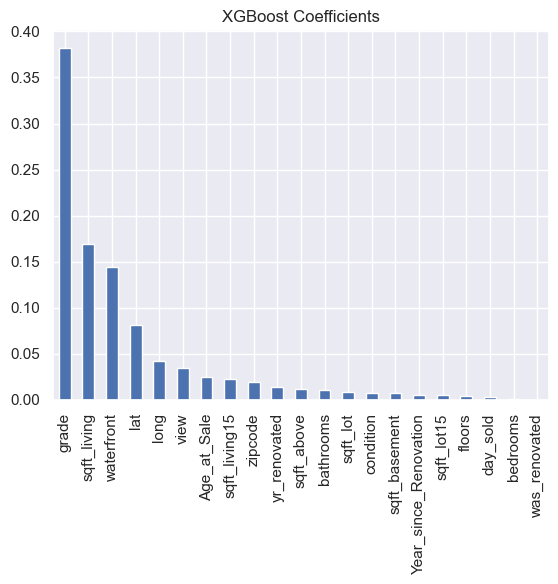

In [30]:
coefs_xgb.plot(kind='bar', title='XGBoost Coefficients')
fig1 = plt.savefig("Graphs/XGBoost_Coefficients.png")
metrics_df
metrics_df.to_csv("ModelMetrics_FE.csv", index=False)
metrics_df